# 将Gated2Depth项目分解逐步处理

### 测试  


In [1]:
x = 290
while True:
    if (1280 - x) % 32 == 0:
        break
    x += 1
    if x > 500: break
print(x)
# 400*960

320


### 文件读取函数

In [2]:
#  Copyright 2018 Algolux Inc. All Rights Reserved.
#  修改自dataset_util.py
import os
import cv2
import numpy as np

crop_size = 160
crop_size_h = 152


# crop_size = 0


def read_gated_image(base_dir, gta_pass, img_id, data_type, num_bits=10, scale_images=False,
                     scaled_img_width=None, scaled_img_height=None,
                     normalize_images=False):
    gated_imgs = []
    normalizer = 2 ** num_bits - 1.

    for gate_id in range(3):
        gate_dir = os.path.join(base_dir, gta_pass, 'gated%d_10bit' % gate_id)
        img = cv2.imread(os.path.join(gate_dir, img_id + '.png'), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
        if data_type == 'real':
            img = img[crop_size_h:(img.shape[0] - crop_size_h), crop_size:(img.shape[1] - crop_size)]
            img = img.copy()
            img[img > 2 ** 10 - 1] = normalizer
        img = np.float32(img / normalizer)
        gated_imgs.append(np.expand_dims(img, axis=2))

    img = np.concatenate(gated_imgs, axis=2)
    if normalize_images:
        mean = np.mean(img, axis=2, keepdims=True)
        std = np.std(img, axis=2, keepdims=True)
        img = (img - mean) / (std + np.finfo(float).eps)
    if scale_images:
        img = cv2.resize(img, dsize=(scaled_img_width, scaled_img_height), interpolation=cv2.INTER_AREA)
    return np.expand_dims(img, axis=0)


def read_gt_image(base_dir, gta_pass, img_id, data_type, min_distance, max_distance, scale_images=False,
                  scaled_img_width=None,
                  scaled_img_height=None, raw_values_only=False):
    if data_type == 'real':
        depth_lidar1 = np.load(
            os.path.join(
                base_dir, gta_pass, "depth_hdl64_gated_compressed",
                img_id + '.npz'))['arr_0']
        depth_lidar1 = depth_lidar1[crop_size_h: (depth_lidar1.shape[0] - crop_size_h),
                       crop_size: (depth_lidar1.shape[1] - crop_size)]
        if raw_values_only:
            return depth_lidar1, None

        gt_mask = (depth_lidar1 > 0.)

        depth_lidar1 = np.float32(np.clip(depth_lidar1, min_distance, max_distance) / max_distance)

        # 数组的形状将变为(1, height, width, 1)
        return np.expand_dims(np.expand_dims(depth_lidar1, axis=2), axis=0), \
            np.expand_dims(np.expand_dims(gt_mask, axis=2), axis=0)
        # return depth_lidar1, gt_mask

    img = np.load(os.path.join(base_dir, gta_pass, 'depth_compressed', img_id + '.npz'))['arr_0']

    if raw_values_only:
        return img, None

    img = np.clip(img, min_distance, max_distance) / max_distance
    if scale_images:
        img = cv2.resize(img, dsize=(scaled_img_width, scaled_img_height), interpolation=cv2.INTER_AREA)

    return np.expand_dims(np.expand_dims(img, axis=2), axis=0), None


def read_depth_prior(dir, img_id):
    gate_dir = os.path.join(base_dir, 'gated3_10bit')
    img = cv2.imread(os.path.join(gate_dir, img_id + '.png'), cv2.IMREAD_ANYCOLOR | cv2.IMREAD_ANYDEPTH)
    img = np.float32(img)
    depth_prior_masks = []
    for i in [30, 100, 180]:
        mi = img == i
        depth_prior_masks.append(mi)
    return depth_prior_masks



### 数据预览

[416, 960]


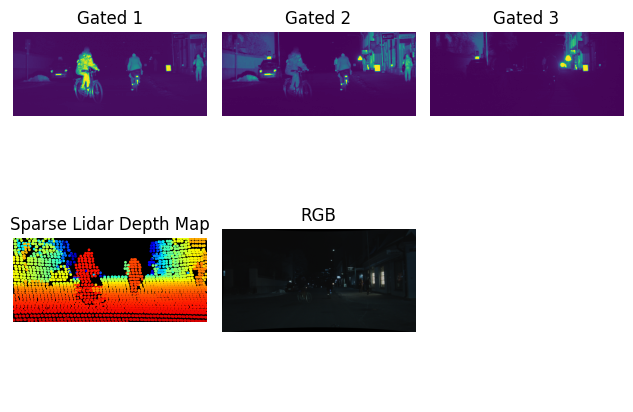

In [3]:
#测试数据读取

import matplotlib.pyplot as plt

base_dir = '../data/real'
gta_pass = ''
data_type = 'real'
img_id = '00024'
min_distance = 3.
max_distance = 150.

# 从数据文件中读取目标图像和激光雷达掩码
in_img = read_gated_image(base_dir, gta_pass, img_id, data_type)
gt_patch, lidar_mask = read_gt_image(base_dir, gta_pass, img_id, data_type, min_distance, max_distance,
                                     # raw_values_only=True
                                     )

# 测试保存concatenate后的数据
in_dir = '../data/real/gated'
depth_dir = '../data/real/depth'
np.save(in_dir + img_id + '.npy', in_img)
laod_in_img = np.load(in_dir + img_id + '.npy')

figShape = [720 - crop_size_h * 2, 1280 - crop_size * 2]
print(figShape)
# 创建一个2x2的子图布局
# plt.figure(figsize=(20, 20))
fig, axs = plt.subplots(2, 3)
# 在子图上绘图
axs[0, 0].set_title('Gated 1')
axs[0, 0].imshow(laod_in_img[:, :, :, 0:1].reshape(figShape))
axs[0, 0].axis('off')

axs[0, 1].set_title('Gated 2')
axs[0, 1].imshow(in_img[:, :, :, 1:2].reshape(figShape))
axs[0, 1].axis('off')

axs[0, 2].set_title('Gated 3')
axs[0, 2].imshow(in_img[:, :, :, 2:3].reshape(figShape))
axs[0, 2].axis('off')

y_coords, x_coords = np.where(lidar_mask.reshape(figShape))
valid_depths = np.where(lidar_mask, gt_patch, np.nan)
axs[1, 0].set_title('Sparse Lidar Depth Map')
axs[1, 0].imshow(np.zeros_like(gt_patch.reshape(figShape)), cmap='gray')
axs[1, 0].scatter(x_coords, y_coords, 
                  c=(gt_patch.reshape(figShape)[lidar_mask.reshape(figShape)]), 
                  cmap='jet_r', s=1, marker='o')
axs[1, 0].axis('off')

RGBimg = cv2.imread(os.path.join(base_dir, 'rgb_left_8bit', img_id + '.png'))
axs[1, 1].set_title('RGB')
axs[1, 1].imshow(RGBimg)
axs[1, 1].axis('off')
axs[1, 2].axis('off')
# 调整子图之间的间距
plt.tight_layout()
plt.show()


### 导包和环境配置

In [4]:
# 准备数据id和预处理GPU环境
import tensorflow as tf
import os
import cv2
import numpy as np
# 准备训练前的库和GPU
import time
import unet
import tqdm
import csv
import gc

base_dir = '../data/real'
gta_pass = ''
data_type = 'real'
# img_id = '01151'
min_distance = 3.
max_distance = 150.

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

data_dir = '../data/real'


# sample_ids = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'gated0_10bit'))]

def readlines(filename):
    """
        Read all the lines in a text file and return as a list
    """
    with open(filename, 'r') as f:
        lines = f.read().splitlines()
    return lines


data_fpath = '../data/real/splits/data'
# 数据加载
fpath = os.path.join(data_fpath, "{}_files.txt")
sample_ids = readlines(fpath.format("train"))

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=9216)])
    except RuntimeError as e:
        print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 损失函数、训练验证函数、指标函数

In [5]:

def calculate_cross_depth_histogram(hist1, hist2):
    # 生成150个等间距的分位点，包括最小值和最大值
    quantiles = tf.linspace(0., 150., 150)

    # 使用 tf.searchsorted 找到每个值属于哪个分位
    indices1 = tf.searchsorted(quantiles, hist1, side='right')
    indices2 = tf.searchsorted(quantiles, hist2, side='right')

    hist1_bin_counts = tf.math.bincount(indices1, minlength=150, maxlength=150)
    hist2_bin_counts = tf.math.bincount(indices2, minlength=150, maxlength=150)
    bin_count_diffs = tf.abs(hist1_bin_counts - hist2_bin_counts)

    # Step 1: Calculate the median of the bin counts
    def calculate_median(tensor):
        tensor_sorted = tf.sort(tensor)
        length = tf.shape(tensor_sorted)[0]

        # print(tf.shape(tensor_sorted))

        middle = length // 2
        return (tensor_sorted[middle - 1] + tensor_sorted[middle]) / 2 if length % 2 == 0 else tensor_sorted[middle]

    median_hist1 = calculate_median(hist1)
    median_hist2 = calculate_median(hist2)

    # Step 2: Find the range of indices between the two medians
    start_idx = tf.minimum(median_hist1, median_hist2)
    end_idx = tf.maximum(median_hist1, median_hist2)
    indices_range = tf.range(start_idx, end_idx + 1, dtype=tf.int64)

    # Step 3: Find the bin with the minimum difference within this range
    min_diff_bin = tf.argmin(tf.gather(bin_count_diffs, indices_range))

    # Convert the index to the actual bin number within the original histogram
    closest_bin = indices_range[min_diff_bin]
    return tf.cast(closest_bin, tf.float32)


def depth_prior_loss_c(predictions, imgDP):
    predictions_ex = predictions * 150.  # 获取预测的深度图 
    predicted_depth = predictions_ex[0, :, :, 0]

    hist1 = tf.reshape(predicted_depth[imgDP[0]], -1)
    hist2 = tf.reshape(predicted_depth[imgDP[1]], -1)
    hist3 = tf.reshape(predicted_depth[imgDP[2]], -1)
    # 如果有hist的shape为0，则返回全是1的权重
    if tf.size(hist1) == 0 or tf.size(hist2) == 0 or tf.size(hist3) == 0:
        return tf.ones_like(predictions)

    # 计算直方交汇点
    s1 = calculate_cross_depth_histogram(hist1, hist2)
    s2 = calculate_cross_depth_histogram(hist2, hist3)

    hist1_loss = predicted_depth - s1
    # 将小于0的数值设置为0
    hist1_loss = tf.nn.relu(hist1_loss)
    hist1_loss *= imgDP[0]

    hist2_loss2 = predicted_depth - s2
    hist2_loss2 = tf.nn.relu(hist2_loss2)
    hist2_loss2 *= imgDP[1]

    hist2_loss1 = s1 - predicted_depth
    hist2_loss1 = tf.nn.relu(hist2_loss1)
    hist2_loss1 *= imgDP[1]

    hist3_loss = s2 - predicted_depth
    hist3_loss = tf.nn.relu(hist3_loss)
    hist3_loss *= imgDP[2]

    loss_weight = hist1_loss + hist2_loss1 + hist2_loss2 + hist3_loss
    # 将数据规约到0-1
    # loss_weight = loss_weight / tf.reduce_max(loss_weight)
    # 将所有小于1的值替换为1
    # loss_weight = tf.where(loss_weight < 1., tf.ones_like(loss_weight), loss_weight)
    # +1
    # loss_weight = loss_weight + tf.ones_like(loss_weight)
    # 将其维度化成predictions的形状
    loss_weight = tf.expand_dims(loss_weight, axis=0)
    loss_weight = tf.expand_dims(loss_weight, axis=-1)
    return loss_weight


def depth_prior_loss_c_1(predictions, imgDP):
    predictions_ex = predictions * 150.  # 获取预测的深度图 
    predicted_depth = predictions_ex[0, :, :, 0]

    hist1 = tf.reshape(predicted_depth[imgDP[0]], -1)
    hist2 = tf.reshape(predicted_depth[imgDP[1]], -1)
    hist3 = tf.reshape(predicted_depth[imgDP[2]], -1)
    # 如果有hist的shape为0，则返回全是1的权重
    if tf.size(hist1) == 0 or tf.size(hist2) == 0 or tf.size(hist3) == 0:
        return tf.ones_like(predictions)

    # 计算直方交汇点
    s1 = calculate_cross_depth_histogram(hist1, hist2)
    s2 = calculate_cross_depth_histogram(hist2, hist3)

    hist1_loss = predicted_depth - s1
    # 将小于0的数值设置为0
    hist1_loss = tf.nn.relu(hist1_loss)
    hist1_loss *= imgDP[0]

    hist2_loss2 = predicted_depth - s2
    hist2_loss2 = tf.nn.relu(hist2_loss2)
    hist2_loss2 *= imgDP[1]

    hist2_loss1 = s1 - predicted_depth
    hist2_loss1 = tf.nn.relu(hist2_loss1)
    hist2_loss1 *= imgDP[1]

    hist3_loss = s2 - predicted_depth
    hist3_loss = tf.nn.relu(hist3_loss)
    hist3_loss *= imgDP[2]

    loss_weight = hist1_loss + hist2_loss1 + hist2_loss2 + hist3_loss
    # 将数据规约到0-1
    # loss_weight = loss_weight / tf.reduce_max(loss_weight)
    # 将所有小于1的值替换为1
    # loss_weight = tf.where(loss_weight < 1., tf.ones_like(loss_weight), loss_weight)
    # +1
    # loss_weight = loss_weight + tf.ones_like(loss_weight)
    # 将其维度化成predictions的形状
    loss_weight = tf.expand_dims(loss_weight, axis=0)
    loss_weight = tf.expand_dims(loss_weight, axis=-1)
    return tf.reduce_sum(loss_weight)


def tv_loss_c(input, g_output):
    dy_out, dx_out = tf.image.image_gradients(g_output)
    dy_out = tf.abs(dy_out)
    dx_out = tf.abs(dx_out)
    dy_input, dx_input = tf.image.image_gradients(tf.reduce_mean(input, axis=3, keepdims=True))
    ep_dy = tf.exp(-tf.abs(dy_input))
    ep_dx = tf.exp(-tf.abs(dx_input))
    grad_loss = tf.reduce_mean(tf.multiply(dy_out, ep_dy) + tf.multiply(dx_out, ep_dx))
    return grad_loss


def mae_loss_c(y_true, y_pred, gt_mask):
    l1_loss = tf.reduce_sum(tf.abs(y_pred - y_true) * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)
    return l1_loss


def loss_c(input, y_true, y_pred, gt_mask, depth_prior_masks, DP_weight=0.0001):
    dp_weights = depth_prior_loss_c(y_pred, depth_prior_masks) * DP_weight + tf.ones_like(y_pred)
    loss_sum = tf.abs(y_pred - y_true)
    weighted = loss_sum * dp_weights
    l1_loss = (tf.reduce_sum(weighted * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps))

    return l1_loss + 0.5 * tv_loss_c(input, y_pred)


def loss_c_1(input, y_true, y_pred, gt_mask, depth_prior_masks, DP_weight=0.0001):
    l1_loss = tf.reduce_sum(tf.abs(y_pred - y_true) * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)
    DP_loss = depth_prior_loss_c_1(y_pred, depth_prior_masks)

    return l1_loss + 0.5 * tv_loss_c(input, y_pred) + DP_loss * DP_weight


# 损失函数和指标
def rmse_c(y_true, y_pred, gt_mask):
    # gt_mask = y_true[..., -1:]
    # y_true = y_true[..., :-1]
    return tf.sqrt(
        tf.reduce_sum(tf.square(y_pred - y_true) * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)) * 150


def mean_relative_error_c(y_true, y_pred, gt_mask):
    relative_error = tf.abs((y_pred - y_true) / (y_true + np.finfo(float).eps))
    return tf.reduce_sum(relative_error * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)


def threshold_c(y_true, y_pred, gt_mask, thr=1.25):
    # 计算最大比率
    ratios_1 = tf.math.divide(y_true, y_pred)
    ratios_2 = tf.math.divide(y_pred, y_true)
    max_ratio = tf.math.maximum(ratios_1, ratios_2)

    # 使用gt_mask作为权重，仅考虑有效值
    valid_comparison = tf.cast(max_ratio < thr, tf.float32) * gt_mask

    # 计算加权均值并乘以100
    result = (tf.reduce_sum(valid_comparison) / tf.reduce_sum(gt_mask)) * 100.

    return result


def record_train_results(start_time, val_mae_metric, val_rmse_metric,
                         val_ARD_metric, val_BETA1_metric,
                         val_BETA2_metric, val_BETA3_metric,
                         epoch_num, lrate, beta1, batch_size,
                         loss_f, DP_weight):
    train_results = [start_time,
                     '{:.2f}'.format(val_mae_metric.result() * 150),
                     '{:.2f}'.format(val_rmse_metric.result()),
                     '{:.4f}'.format(val_ARD_metric.result()),
                     '{:.2f}'.format(val_BETA1_metric.result()),
                     '{:.2f}'.format(val_BETA2_metric.result()),
                     '{:.2f}'.format(val_BETA3_metric.result()),
                     epoch_num,
                     lrate,
                     beta1,
                     batch_size,
                     loss_f,
                     720 - crop_size_h * 2,
                     1280 - crop_size * 2,
                     DP_weight]

    # 使用追加模式打开文件，这样新的训练结果会被添加到文件的末尾
    with open('train_results.csv', 'a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(train_results)


# 手动训练
def train_c(epoch_num, lrate, beta1, start_time, batch_size=1, DP_weight=0.0001):
    input_img = tf.keras.Input(shape=(720 - crop_size_h * 2, 1280 - crop_size * 2, 3))
    outputs = unet.build_unet(input_img)

    model = tf.keras.Model(inputs=input_img, outputs=outputs)

    # 4. 选择优化器
    optimizer = tf.keras.optimizers.Adam(learning_rate=lrate, beta_1=beta1)

    train_mae_metric = tf.keras.metrics.Mean(name='train_MAE')
    train_rmse_metric = tf.keras.metrics.Mean(name='train_RMSE')
    losses = tf.keras.metrics.Mean(name='train_Losses')
    # test_mae_metric = tf.keras.metrics.Mean(name='test_MAE')

    # 5. 手动训练模型
    for epoch in range(epoch_num):
        with tqdm.tqdm(total=len(sample_ids), desc='Epoch ' + str(epoch)) as pbar:
            # for x_batch, y_batch in dataset:
            for id in sample_ids:
                # 读数据
                x_batch = read_gated_image(base_dir, gta_pass, id, data_type)
                gt_patch, lidar_mask = read_gt_image(base_dir, gta_pass, id, data_type, min_distance, max_distance)
                lidar_mask = lidar_mask.astype('float32')
                depth_prior = read_depth_prior(base_dir, id)

                with tf.GradientTape() as tape:
                    y_pred = model(x_batch)
                    # loss = mae_loss_c(gt_patch, y_pred, lidar_mask)
                    loss = loss_c(x_batch, gt_patch, y_pred, lidar_mask, depth_prior, DP_weight)

                grads = tape.gradient(loss, model.trainable_weights)
                optimizer.apply_gradients(zip(grads, model.trainable_weights))

                batch_mae = mae_loss_c(gt_patch, y_pred, lidar_mask)
                batch_rmse = rmse_c(gt_patch, y_pred, lidar_mask)
                train_mae_metric(batch_mae)
                train_rmse_metric(batch_rmse)
                losses(loss)
                pbar.set_postfix(Loss="{:.4f}".format(losses.result()),
                                 MAE="{:.2f}".format(train_mae_metric.result() * 150),
                                 RMSE="{:.4f}".format(train_rmse_metric.result()))
                pbar.update(1)

            template = 'Epoch {}, Train MAE: {}, Train RMSE: {}'
            # print(template.format(epoch, train_mae_metric.result(), train_rmse_metric.result()))
    model.save_weights('models/newG2D-weight_' + start_time + '.h5')

    del model  # 删除模型对象

    gc.collect()  # 执行垃圾回收

    tf.keras.backend.clear_session()  # 清除当前TF计算图


# 测试模型
# 加载模型
def eval_c(epoch_num, lrate, beta1, start_time, batch_size=1, loss_f='L1', DP_weight=0.0001):
    input_img = tf.keras.Input(shape=(720 - crop_size_h * 2, 1280 - crop_size * 2, 3))
    outputs = unet.build_unet(input_img)
    model = tf.keras.Model(inputs=input_img, outputs=outputs)
    model.load_weights('models/newG2D-weight_' + start_time + '.h5')

    # 验证集
    sample_ids_val = readlines(fpath.format("val"))

    val_mae_metric = tf.keras.metrics.Mean(name='val_MAE')
    val_rmse_metric = tf.keras.metrics.Mean(name='val_RMSE')
    val_ARD_metric = tf.keras.metrics.Mean(name='val_ARD')
    val_BETA1_metric = tf.keras.metrics.Mean(name='val_BETA1')
    val_BETA2_metric = tf.keras.metrics.Mean(name='val_BETA2')
    val_BETA3_metric = tf.keras.metrics.Mean(name='val_BETA3')

    with tqdm.tqdm(total=len(sample_ids_val), desc='Validation ') as pbar:
        for id in sample_ids_val:
            x_batch = read_gated_image(base_dir, gta_pass, id, data_type)
            gt_patch, lidar_mask = read_gt_image(base_dir, gta_pass, id, data_type, min_distance, max_distance)
            lidar_mask = lidar_mask.astype('float32')

            y_pred = model(x_batch)

            val_mae_metric(mae_loss_c(gt_patch, y_pred, lidar_mask))
            val_rmse_metric(rmse_c(gt_patch, y_pred, lidar_mask))
            val_ARD_metric(mean_relative_error_c(gt_patch, y_pred, lidar_mask))
            val_BETA1_metric(threshold_c(gt_patch, y_pred, lidar_mask, thr=1.25))
            val_BETA2_metric(threshold_c(gt_patch, y_pred, lidar_mask, thr=1.25 ** 2))
            val_BETA3_metric(threshold_c(gt_patch, y_pred, lidar_mask, thr=1.25 ** 3))

            pbar.update(1)

    # 显示验证集结果
    template = 'Val MAE: {:.2f}, Val RMSE: {:.2f}, Val ARD: {:.4f}, Val Beta1: {:.2f}, Val Beta2: {:.2f}, Val Beta3: {:.2f}'
    # print(template.format(
    #     val_mae_metric.result() * 150,
    #     val_rmse_metric.result(),
    #     val_ARD_metric.result(),
    #     val_BETA1_metric.result(),
    #     val_BETA2_metric.result(),
    #     val_BETA3_metric.result()
    # ))

    record_train_results(start_time, val_mae_metric, val_rmse_metric,
                         val_ARD_metric, val_BETA1_metric,
                         val_BETA2_metric, val_BETA3_metric,
                         epoch_num, lrate, beta1, batch_size,
                         loss_f, DP_weight)
    del model  # 删除模型对象

    gc.collect()  # 执行垃圾回收

    tf.keras.backend.clear_session()  # 清除当前TF计算图


### 训练和验证

In [6]:
epochs = 3
lrate = 1e-4
beta1 = 0.9
batch_size = 1
loss_f = 'L1+TV+DP'
DP_weight = 0.0001


def train_eval_save(epochs, lrate, beta1, batch_size, loss_f='L1', DP_weight=0.0001):
    start_time = time.strftime("%H_%M_d_%d_%m_%Y", time.localtime())
    train_c(epochs, lrate, beta1, start_time, batch_size, DP_weight)
    eval_c(epochs, lrate, beta1, start_time, batch_size, loss_f, DP_weight)



In [ ]:
# 单次运行
print(epochs, lrate, beta1, batch_size, loss_f, DP_weight, sep=' | ')
train_eval_save(epochs, lrate, beta1, batch_size, loss_f, DP_weight)

3 | 0.0001 | 0.9 | 1 | L1+TV+DP | 0.0001


Epoch 0:  46%|████▌     | 1846/4014 [05:37<06:39,  5.43it/s, Loss=0.0560, MAE=7.59, RMSE=12.7757]

In [ ]:
# 测试beta1参数对验证集的影响
for beta1_d in [0.6, 0.7, 0.8, 0.9, 0.95, 0.99]:
    train_eval_save(epochs, lrate, beta1_d, batch_size)

In [9]:
# 测试epoch和学习率对验证集的影响
# 9*6*10=540/60=9h
for epochs_d in [2, 3, 4]:
    for lrate_d in [1e-3, 1e-4, 2e-4, 4e-4, 9e-5, 7e-5]:
        train_eval_save(epochs_d, lrate_d, beta1, batch_size)



Validation : 100%|██████████| 446/446 [00:44<00:00, 10.10it/s]


In [11]:


for epochs_d in [5, 6]:
    for lrate_d in [1e-4, 7e-5]:
        train_eval_save(epochs_d, lrate_d, beta1, batch_size)

Validation : 100%|██████████| 446/446 [00:48<00:00,  9.14it/s]


### 模型输出和可视化比较

(416, 960)


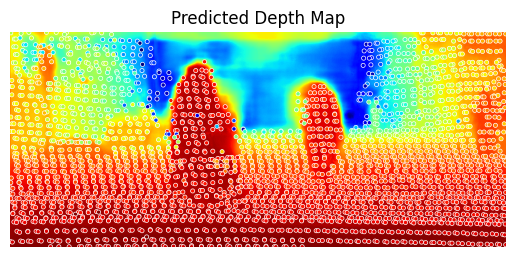

In [41]:

input_img = tf.keras.Input(shape=(720 - crop_size_h * 2, 1280 - crop_size * 2, 3))
outputs = unet.build_unet(input_img)
model = tf.keras.Model(inputs=input_img, outputs=outputs)
model.load_weights('models/newG2D-weight_16_18_d_27_11_2023.h5')

in_img = read_gated_image(base_dir, gta_pass, img_id, data_type)  # 扩展数据的维度以匹配模型的输入维度 
# inputs = tf.expand_dims(in_img, axis=0) # 使用模型进行预测 
predictions = model(in_img) * 150  # 获取预测的深度图 
predicted_depth = predictions[0, :, :, 0]
print(predicted_depth.shape)
plt.imshow(predicted_depth, cmap='jet_r')
plt.scatter(x_coords, y_coords, c=150*(gt_patch.reshape(figShape)[lidar_mask.reshape(figShape)]), 
            cmap='jet_r', s=9, marker='o', edgecolors='white', linewidths=0.5)
# plt.colorbar()
plt.title("Predicted Depth Map")
plt.axis('off')
plt.show()

(416, 960)


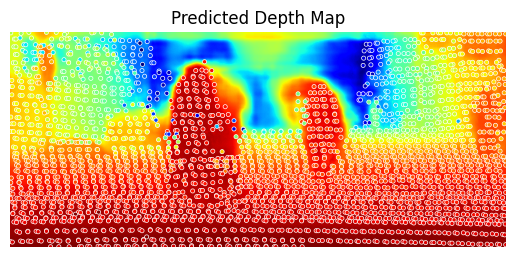

In [40]:

input_img = tf.keras.Input(shape=(720 - crop_size_h * 2, 1280 - crop_size * 2, 3))
outputs = unet.build_unet(input_img)
model = tf.keras.Model(inputs=input_img, outputs=outputs)
model.load_weights('models/newG2D-weight_20_46_d_10_11_2023.h5')

in_img = read_gated_image(base_dir, gta_pass, img_id, data_type)  # 扩展数据的维度以匹配模型的输入维度 
# inputs = tf.expand_dims(in_img, axis=0) # 使用模型进行预测 
predictions = model(in_img) * 150  # 获取预测的深度图 
predicted_depth = predictions[0, :, :, 0]
print(predicted_depth.shape)
plt.imshow(predicted_depth, cmap='jet_r')
# 绘制白边圆点散点图
plt.scatter(x_coords, y_coords, c=150*(gt_patch.reshape(figShape)[lidar_mask.reshape(figShape)]), 
            cmap='jet_r', s=9, marker='o', edgecolors='white', linewidths=0.5)
# plt.colorbar()
plt.title("Predicted Depth Map")
plt.axis('off')
plt.show()

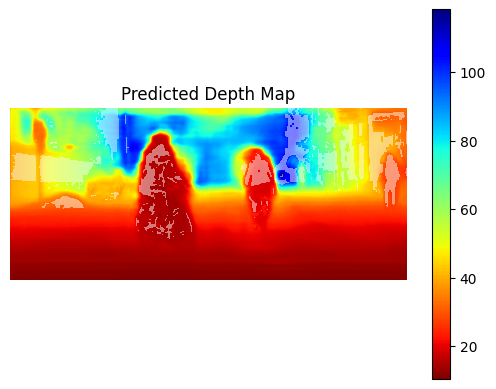

In [8]:
base_dir = '../data/real'
imgDP = read_depth_prior(base_dir, img_id)

# 创建一个全白的图像
white_overlay = np.ones((*predicted_depth.shape, 4))  # 最后一个维度是 RGBA，A 是透明度
white_overlay[:, :, 3] = 0.5  # 半透明

plt.imshow(predicted_depth, cmap='jet_r')
plt.colorbar()
# 将掩码叠加在深度图上
plt.imshow(np.ma.masked_where(imgDP[0] == False, imgDP[0]), cmap='Reds', alpha=0.5)  # 掩码1标为红色
plt.imshow(np.ma.masked_where(imgDP[1] == False, imgDP[1]), cmap='Greens', alpha=0.5)  # 掩码2标为绿色
plt.imshow(np.ma.masked_where(imgDP[2] == False, imgDP[2]), cmap='Blues', alpha=0.5)  # 掩码3标为蓝色

plt.title("Predicted Depth Map")
plt.axis('off')
plt.show()


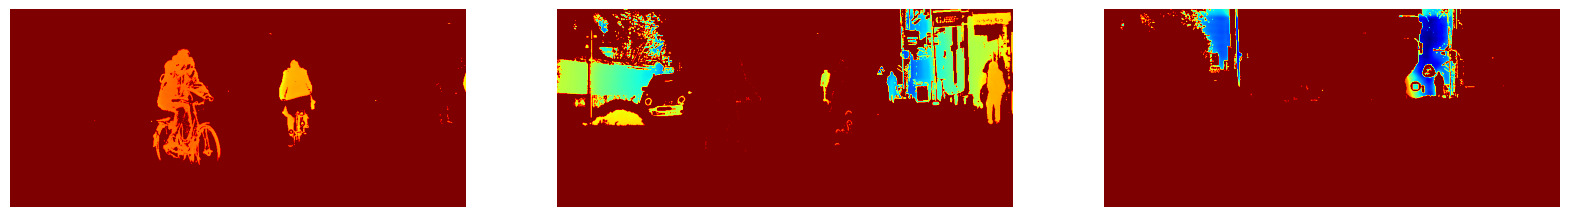

In [8]:
# 测试read_depth_prior函数
import matplotlib.pyplot as plt

base_dir = '../data/real'
imgDP = read_depth_prior(base_dir, img_id)

#画三个子图显示imgDP的三个通道，设置画布大小为6*20
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# 对predicted_depth只绘制imgDP掩码区域
axs[0].imshow(predicted_depth * imgDP[0], cmap='jet_r')
axs[0].axis('off')
axs[1].imshow(predicted_depth * imgDP[1], cmap='jet_r')
axs[1].axis('off')
axs[2].imshow(predicted_depth * imgDP[2], cmap='jet_r')
axs[2].axis('off')
plt.show()


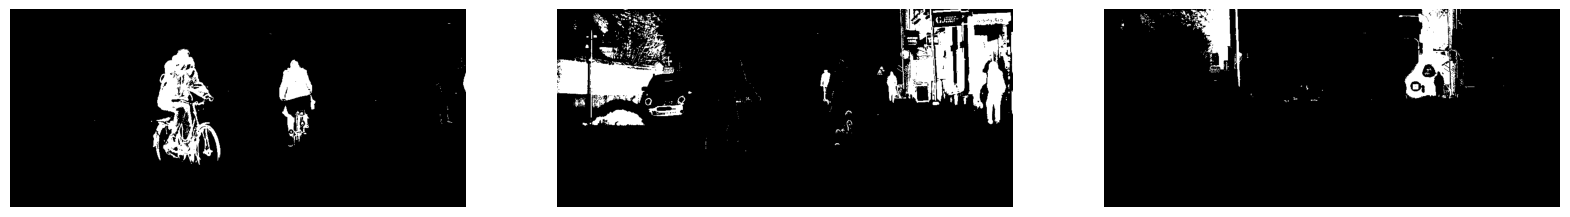

In [21]:
# 测试read_depth_prior函数
import matplotlib.pyplot as plt

#画三个子图显示imgDP的三个通道，设置画布大小为6*20
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
# 在子图上绘图
axs[0].imshow(imgDP[0], cmap='gray')
axs[0].axis('off')
axs[1].imshow(imgDP[1], cmap='gray')
axs[1].axis('off')
axs[2].imshow(imgDP[2], cmap='gray')
axs[2].axis('off')
plt.show()




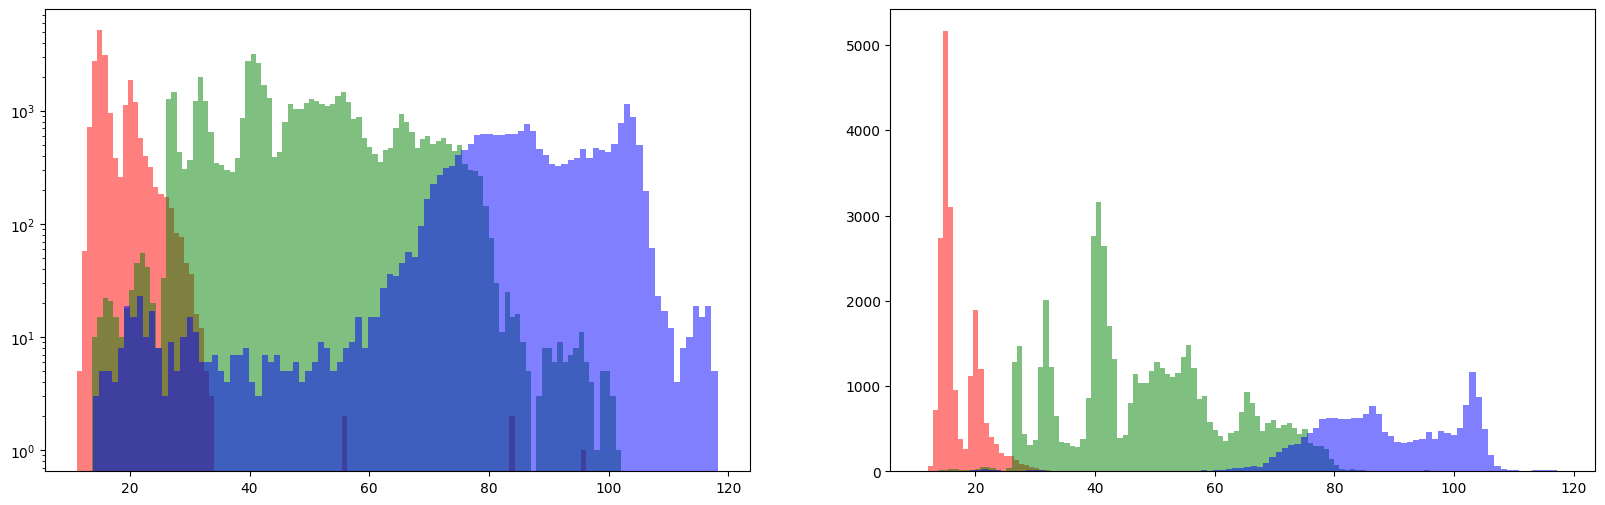

In [10]:
# 加入DP损失后的直方图
hist1 = tf.reshape(predicted_depth[imgDP[0]], -1)
hist2 = tf.reshape(predicted_depth[imgDP[1]], -1)
hist3 = tf.reshape(predicted_depth[imgDP[2]], -1)

# 画出predicted_depth在imgDP掩码区域的直方图
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].hist(hist1, bins=100, color='red', alpha=0.5)
axs[0].hist(hist2, bins=100, color='green', alpha=0.5)
axs[0].hist(hist3, bins=100, color='blue', alpha=0.5)
# 设置y轴为非线性
axs[0].set_yscale('log')

axs[1].hist(hist1, bins=100, color='red', alpha=0.5)
axs[1].hist(hist2, bins=100, color='green', alpha=0.5)
axs[1].hist(hist3, bins=100, color='blue', alpha=0.5)
# plt.ylim(0, 1000)
plt.show()

tf.Tensor(23, shape=(), dtype=int64)


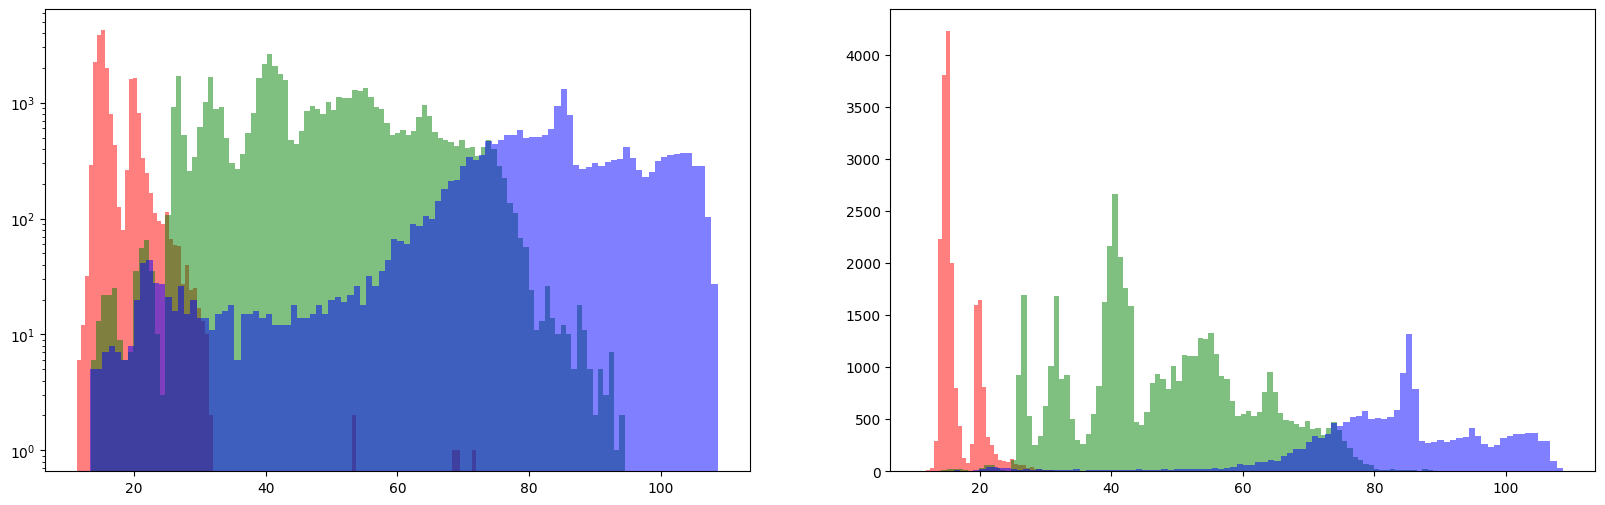

In [37]:
# 距离-像素数量直方图
hist1 = tf.reshape(predicted_depth[imgDP[0]], -1)
hist2 = tf.reshape(predicted_depth[imgDP[1]], -1)
hist3 = tf.reshape(predicted_depth[imgDP[2]], -1)

# 画出predicted_depth在imgDP掩码区域的直方图
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].hist(hist1, bins=100, color='red', alpha=0.5)
axs[0].hist(hist2, bins=100, color='green', alpha=0.5)
axs[0].hist(hist3, bins=100, color='blue', alpha=0.5)
# 设置y轴为非线性
axs[0].set_yscale('log')

axs[1].hist(hist1, bins=100, color='red', alpha=0.5)
axs[1].hist(hist2, bins=100, color='green', alpha=0.5)
axs[1].hist(hist3, bins=100, color='blue', alpha=0.5)
# plt.ylim(0, 1000)
plt.show()


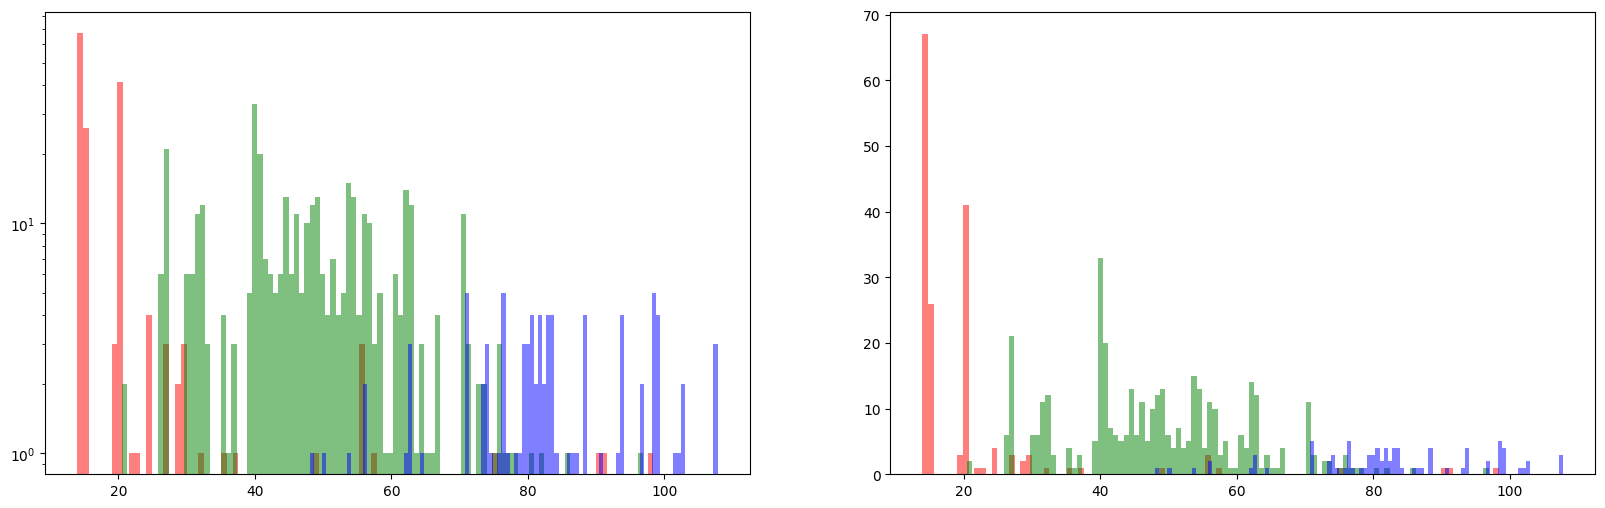

In [88]:
# 雷达在DP掩码下的直方图
gt_patch_depth = gt_patch[0, :, :, 0]*150
lidar_mask_r = lidar_mask.reshape(figShape)
hist1 = tf.reshape(gt_patch_depth[imgDP[0]*lidar_mask_r], -1)
hist2 = tf.reshape(gt_patch_depth[imgDP[1]*lidar_mask_r], -1)
hist3 = tf.reshape(gt_patch_depth[imgDP[2]*lidar_mask_r], -1)

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].hist(hist1, bins=100, color='red', alpha=0.5)
axs[0].hist(hist2, bins=100, color='green', alpha=0.5)
axs[0].hist(hist3, bins=100, color='blue', alpha=0.5)
# 设置y轴为非线性
axs[0].set_yscale('log')

axs[1].hist(hist1, bins=100, color='red', alpha=0.5)
axs[1].hist(hist2, bins=100, color='green', alpha=0.5)
axs[1].hist(hist3, bins=100, color='blue', alpha=0.5)
# plt.ylim(0, 1000)
plt.show()



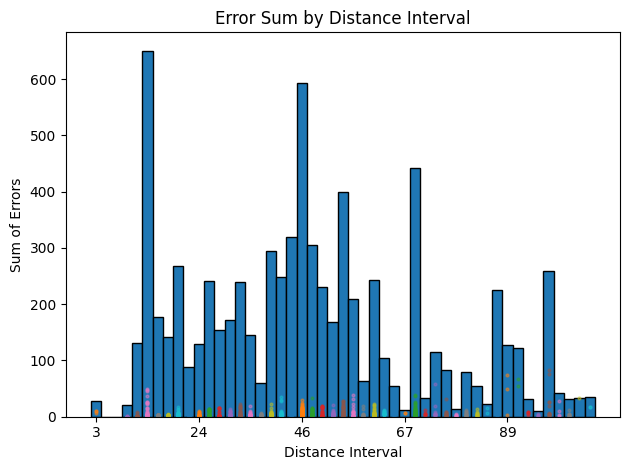

In [84]:
# 输出误差直方-散点图

# 假设数据 - 请用你的实际数据替换这些
sparse_radar_matrix = gt_patch.reshape(figShape)*150 # 稀疏雷达矩阵
full_depth_matrix = predicted_depth  # 全分辨率深度矩阵
mask = lidar_mask.reshape(figShape)  # 掩码，表示有效值

# 应用掩码，选取有效值
valid_radar = sparse_radar_matrix[mask]
valid_depth = full_depth_matrix[mask]

errors = np.abs(valid_radar - valid_depth)


# 定义距离区间
bins = np.linspace(min(valid_radar), max(valid_radar), num=50)

# 计算每个区间的误差总和
error_sums = []
for i in range(len(bins)-1):
    mask = (valid_radar >= bins[i]) & (valid_radar < bins[i+1])
    error_sum = np.sum(errors[mask])
    error_sums.append(error_sum)

# 绘制直方图
# plt.bar(range(len(error_sums)), error_sums, width=1)
bar_container = plt.bar(range(len(error_sums)), error_sums, width=1, edgecolor='black')

# 在每个直方图柱子上添加散点图
for i in range(len(bins)-1):
    mask = (valid_radar >= bins[i]) & (valid_radar < bins[i+1])
    plt.scatter([i]*sum(mask), errors[mask], alpha=0.5, s=4)
    
# 设置x轴标签为区间
plt.xticks(range(0, len(error_sums), 10), ['{:.0f}'.format(bins[i]) for i in range(0, len(bins)-1, 10)])

# 添加标题和轴标签
plt.title('Error Sum by Distance Interval')
plt.xlabel('Distance Interval')
plt.ylabel('Sum of Errors')

# 显示图表
plt.tight_layout()
plt.show()




C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\numpy\lib\function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
C:\Users\edric\PycharmProjects\newG2D\venv\lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


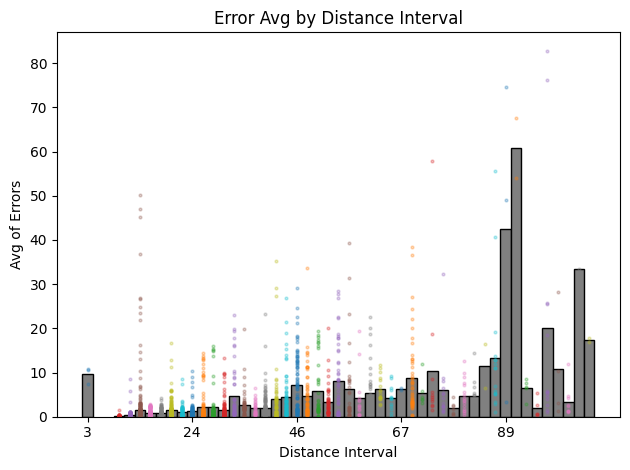

In [87]:
# 计算每个区间的误差均值
error_sums = []
for i in range(len(bins)-1):
    mask = (valid_radar >= bins[i]) & (valid_radar < bins[i+1])
    error_sum = np.average(errors[mask])
    error_sums.append(error_sum)

# 绘制直方图
# plt.bar(range(len(error_sums)), error_sums, width=1)
bar_container = plt.bar(range(len(error_sums)), error_sums, width=1, edgecolor='black', color='gray')

# 在每个直方图柱子上添加散点图
for i in range(len(bins)-1):
    mask = (valid_radar >= bins[i]) & (valid_radar < bins[i+1])
    plt.scatter([i]*sum(mask), errors[mask], alpha=0.3, s=4, marker='o')
    
# 设置x轴标签为区间
plt.xticks(range(0, len(error_sums), 10), ['{:.0f}'.format(bins[i]) for i in range(0, len(bins)-1, 10)])

# 添加标题和轴标签
plt.title('Error Avg by Distance Interval')
plt.xlabel('Distance Interval')
plt.ylabel('Avg of Errors')
# plt.ylim(0, 150)
# 显示图表
plt.tight_layout()
plt.show()

In [13]:

DP_weights = depth_prior_loss_c_1(predictions, imgDP)
print(DP_weights*DP_weight)

tf.Tensor(5.5599184, shape=(), dtype=float32)


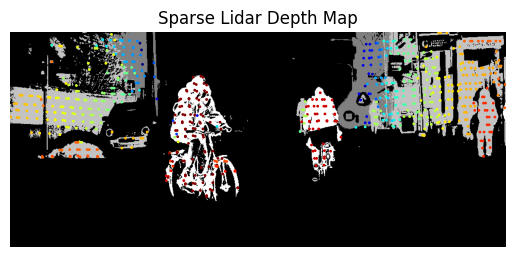

In [94]:
# 在雷达散点图上画出掩码区域，用灰色表示掩码区域
plt.title('Sparse Lidar Depth Map')
plt.imshow(np.zeros_like(gt_patch.reshape(figShape)), cmap='gray')
plt.imshow(imgDP[0]+(imgDP[1]/1.3)+ (imgDP[2]/2), cmap='gray')

y_coords_DP, x_coords_DP = np.where(lidar_mask.reshape(figShape)*(imgDP[0]+imgDP[1]+ imgDP[2]))
plt.scatter(x_coords_DP, y_coords_DP,
            c=(gt_patch.reshape(figShape)[lidar_mask.reshape(figShape)*(imgDP[0]+imgDP[1]+ imgDP[2])]) * 150,
            cmap='jet_r',
            s=1,
            marker='o')
plt.axis('off')
# plt.colorbar()
plt.show()

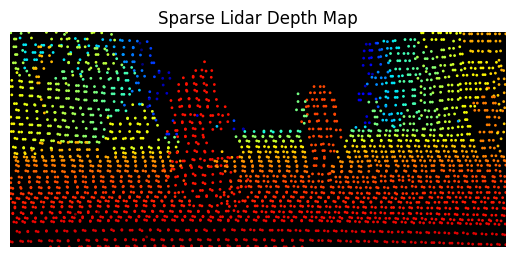

In [17]:
plt.title('Sparse Lidar Depth Map')
plt.imshow(np.zeros_like(gt_patch.reshape(figShape)), cmap='gray')
plt.scatter(x_coords, y_coords,
            c=(gt_patch.reshape(figShape)[lidar_mask.reshape(figShape)]) * 150,
            cmap='jet_r',
            s=1,
            marker='o')
plt.axis('off')
# plt.colorbar()
plt.show()

### 旧代码

In [14]:
input_img = tf.keras.Input(shape=(464, 1024, 3))
outputs = unet.build_unet(input_img)
model = tf.keras.Model(inputs=input_img, outputs=outputs)
model.load_weights('models/newG2D-weight_19_30_d_07_11_2023.h5')

in_img = read_gated_image(base_dir, gta_pass, img_id, data_type)  # 扩展数据的维度以匹配模型的输入维度 
# inputs = tf.expand_dims(in_img, axis=0) # 使用模型进行预测 
predictions = model(in_img) * 150  # 获取预测的深度图 
predicted_depth = predictions[0, :, :, 0]
print(predicted_depth.shape)  # 使用matplotlib显示图像 
plt.imshow(predicted_depth, cmap='gist_rainbow')  # 使用viridis颜色映射 # 
plt.colorbar()
plt.title("Predicted Depth Map")
plt.axis('off')
plt.show()

ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 464, 1024, 3), found shape=(1, 512, 1024, 3)

In [ ]:
# dataset加载数据
def load_sample(sample_id):
    if isinstance(sample_id, tf.Tensor):
        sample_id = sample_id.numpy().decode('utf-8')
    input1_path = os.path.join(data_dir, 'gated0_10bit', sample_id + '.png')
    input2_path = os.path.join(data_dir, 'gated1_10bit', sample_id + '.png')
    input3_path = os.path.join(data_dir, 'gated2_10bit', sample_id + '.png')
    depth_path = os.path.join(data_dir, 'depth_hdl64_gated_compressed', sample_id + '.npz')

    # 设置阈值和normalizer
    threshold = 2 ** 10 - 1
    normalizer_value = 2 ** 10 - 1
    # 设置裁剪大小
    crop_size = 128

    input1 = tf.image.decode_png(tf.io.read_file(input1_path), channels=1)
    input1 = tf.cast(input1, tf.float32)
    # 获取图像的高度和宽度
    height, width, _ = input1.shape
    # 使用tf.image.crop_to_bounding_box裁剪图像
    input1 = tf.image.crop_to_bounding_box(input1, crop_size, crop_size,
                                           height - 2 * crop_size, width - 2 * crop_size)
    normalizer = tf.constant(normalizer_value, dtype=tf.float32)
    # 使用tf.where处理大于阈值的像素
    img_tensor = tf.where(input1 > threshold, normalizer, input1)
    # 将图像张量转换为float32并除以normalizer
    input1 = tf.cast(img_tensor, tf.float32) / normalizer

    input2 = tf.image.decode_png(tf.io.read_file(input2_path), channels=1)
    input2 = tf.cast(input2, tf.float32)
    # 获取图像的高度和宽度
    height, width, _ = input2.shape
    # 使用tf.image.crop_to_bounding_box裁剪图像
    input2 = tf.image.crop_to_bounding_box(input2, crop_size, crop_size,
                                           height - 2 * crop_size, width - 2 * crop_size)
    normalizer = tf.constant(normalizer_value, dtype=tf.float32)
    # 使用tf.where处理大于阈值的像素
    img_tensor = tf.where(input2 > threshold, normalizer, input2)
    # 将图像张量转换为float32并除以normalizer
    input2 = tf.cast(img_tensor, tf.float32) / normalizer

    input3 = tf.image.decode_png(tf.io.read_file(input3_path), channels=1)
    input3 = tf.cast(input3, tf.float32)
    # 获取图像的高度和宽度
    height, width, _ = input3.shape
    # 使用tf.image.crop_to_bounding_box裁剪图像
    input3 = tf.image.crop_to_bounding_box(input3, crop_size, crop_size,
                                           height - 2 * crop_size, width - 2 * crop_size)
    normalizer = tf.constant(normalizer_value, dtype=tf.float32)
    # 使用tf.where处理大于阈值的像素
    img_tensor = tf.where(input3 > threshold, normalizer, input3)
    # 将图像张量转换为float32并除以normalizer
    input3 = tf.cast(img_tensor, tf.float32) / normalizer

    depth = np.load(depth_path)['arr_0']
    depth = depth[crop_size: (depth.shape[0] - crop_size), crop_size: (depth.shape[1] - crop_size)]
    depth = np.expand_dims(depth, axis=2)  #改为[height, width, 1]
    gt_mask = (depth > 0.)
    depth = np.float32(np.clip(depth, min_distance, max_distance) / max_distance)
    y_true_with_mask = tf.concat([depth, gt_mask], axis=-1)

    inputs = tf.stack([input1, input2, input3], axis=-1)
    inputs = tf.squeeze(inputs, axis=-2)  #将数据形状更改为[height, width, 3],以适应网络
    return inputs, y_true_with_mask


inputs1, depth1 = load_sample(sample_ids[25])

dataset = tf.data.Dataset.from_tensor_slices(sample_ids)
dataset = dataset.map(
    lambda x: tf.py_function(
        load_sample, [x], [tf.float32, tf.float32]),
    # num_parallel_calls=tf.data.experimental.AUTOTUNE
)

# dataset = (dataset.shuffle(1024).batch(4).prefetch(tf.data.experimental.AUTOTUNE))
dataset = (dataset.shuffle(1024).batch(1))

sample_ids_val = readlines(fpath.format("val"))
dataset_val = tf.data.Dataset.from_tensor_slices(sample_ids_val)
dataset_val = dataset_val.map(
    lambda x: tf.py_function(
        load_sample, [x], [tf.float32, tf.float32]),
)
dataset_val = (dataset_val.shuffle(1024).batch(1))

num_samples = len(sample_ids)  # 这应该是14227 
num_test_samples = int(0.1 * num_samples)  # 10%的样本作为测试集  
# test_dataset = dataset.take(num_test_samples) 
# train_dataset = dataset.skip(num_test_samples)

In [ ]:
#测试unet
import unet
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger

gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(
                memory_limit=9216)])
    except RuntimeError as e:
        print(e)


def rmse(y_true, y_combined_pred):
    y_pred = y_combined_pred[..., -1:]
    gt_mask = y_true[..., -1:]
    y_true = y_true[..., :-1]
    return tf.sqrt(
        tf.reduce_sum(tf.square(y_pred - y_true) * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)) * 150


def mean_relative_error(y_true, y_combined_pred):
    y_pred = y_combined_pred[..., -1:]
    gt_mask = y_true[..., -1:]
    y_true = y_true[..., :-1]
    relative_error = tf.abs((y_pred - y_true) / (y_true + np.finfo(float).eps))
    return tf.reduce_sum(relative_error * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)


def mae(y_true, y_combined_pred):
    y_pred = y_combined_pred[..., -1:]
    # tf.print(" Shape of y_true:", tf.shape(y_true))
    # tf.print(" Shape of y_pred:", tf.shape(y_pred))
    gt_mask = y_true[..., -1:]
    y_true = y_true[..., :-1]  # 移除gt_mask以得到真实的y_true

    l1_loss = tf.reduce_sum(tf.abs(y_pred - y_true) * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)
    return l1_loss * 150


def mae_loss(y_true, y_combined_pred):
    y_pred = y_combined_pred[..., -1:]
    gt_mask = y_true[..., -1:]
    y_true = y_true[..., :-1]  # 移除gt_mask以得到真实的y_true

    l1_loss = tf.reduce_sum(tf.abs(y_pred - y_true) * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)
    return l1_loss


def tv_loss(input, g_output):
    dy_out, dx_out = tf.image.image_gradients(g_output)
    dy_out = tf.abs(dy_out)
    dx_out = tf.abs(dx_out)
    dy_input, dx_input = tf.image.image_gradients(tf.reduce_mean(input, axis=3, keepdims=True))
    ep_dy = tf.exp(-tf.abs(dy_input))
    ep_dx = tf.exp(-tf.abs(dx_input))
    grad_loss = tf.reduce_mean(tf.multiply(dy_out, ep_dy) + tf.multiply(dx_out, ep_dx))
    return grad_loss


def custom_l1_loss_lamda(y_true, y_combined_pred):
    y_pred = y_combined_pred[..., -1:]  # 输出只有一个通道
    inputs = y_combined_pred[..., :-1]
    # tf.print(" Shape of y_true:", tf.shape(y_true))
    # tf.print(" Shape of y_pred:", tf.shape(y_pred))
    gt_mask = y_true[..., -1:]
    y_true = y_true[..., :-1]  # 移除gt_mask以得到真实的y_true

    l1_loss = tf.reduce_sum(tf.abs(y_pred - y_true) * gt_mask) / (tf.reduce_sum(gt_mask) + np.finfo(float).eps)
    # 平滑损失的权重     
    smooth_weight = 0.3
    # loss = l1_loss + smooth_weight * smoothness_loss(y_pred)
    loss = l1_loss + smooth_weight * tv_loss(input=inputs, g_output=y_pred)
    return loss


input_img = tf.keras.Input(shape=(464, 1024, 3))
# input_img = tf.keras.Input(shape=(720, 1280, 3))
outputs = unet.build_unet(input_img)

# 1.使用Lambda层将输入和输出连接起来
combined_output = tf.keras.layers.Lambda(lambda x: tf.concat(x, axis=-1))([input_img, outputs])
model = tf.keras.Model(inputs=input_img, outputs=combined_output)

# model = tf.keras.Model(inputs=input_img, outputs=unet.build_unet(input_img))
csv_logger = CSVLogger('training_log.csv', append=True)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0.5),
              loss=mae_loss,
              metrics=[rmse, mean_relative_error, mae])
model.summary()

In [ ]:

history = model.fit(dataset,
                    # validation_data=dataset_val,
                    epochs=3,
                    batch_size=1,
                    callbacks=[csv_logger])

In [ ]:

model.save_weights('newG2D-weight_11.h5')

In [ ]:

inputs, _ = load_sample(img_id)
# 扩展数据的维度以匹配模型的输入维度
inputs = tf.expand_dims(inputs, axis=0)
# 使用模型进行预测
predictions = model.predict(inputs)[..., -1:]
# 获取预测的深度图
predicted_depth = predictions[0, :, :, 0]
print(predicted_depth.shape)
# 使用matplotlib显示图像
plt.imshow(1. / predicted_depth, cmap='viridis')  # 使用viridis颜色映射
# plt.colorbar()
plt.title("Predicted Depth Map")
plt.axis('off')
plt.show()

In [ ]:
plt.title('RGB')
plt.imshow(RGBimg)
plt.axis('off')
plt.show()